In [27]:
import pandas as pd
from matplotlib import pyplot as plt
import statsmodels.api as sm
import numpy as np
from sklearn.model_selection import train_test_split
np.set_printoptions(precision=2, suppress=True)
%matplotlib inline

In [28]:
df = pd.read_csv("../data/Phoneme Recognition.txt")
df = df[(df.g == 'aa')|(df.g == 'ao')]
df.g = pd.get_dummies(df.g)['aa']
names = [f'x.{i+1}' for i in range(256)]
df.head()

,row.names,x.1,x.2,x.3,x.4,x.5,x.6,x.7,x.8,x.9,...,x.249,x.250,x.251,x.252,x.253,x.254,x.255,x.256,g,speaker
4,5,12.96705,13.69454,14.91182,18.22292,18.45390,17.25760,17.79614,17.76387,18.99632,...,8.00151,7.58624,6.65202,7.69109,6.93683,7.03600,7.01278,8.52197,1,train.dr1.mcpm0.sa1
6,7,10.95324,11.20585,16.17634,18.59300,17.50922,10.27798,16.00151,19.32894,18.84554,...,8.76707,6.94130,8.79901,8.22345,7.63610,8.44448,8.28905,8.04018,1,train.dr1.mcpm0.sa1
8,9,9.37324,11.29505,17.15139,18.03336,14.95980,14.97031,18.63124,18.77625,11.35160,...,6.53453,6.95005,6.46091,4.18584,6.27844,7.73464,7.41363,0.53710,0,train.dr1.mcpm0.sa1
9,10,9.48477,11.38758,16.74884,17.36141,14.67661,15.02621,18.28174,17.79015,13.96172,...,8.30466,9.12239,7.03513,9.24298,8.77743,8.20530,9.75466,8.49344,0,train.dr1.mcpm0.sa1
13,14,11.62344,15.35490,18.85450,18.85172,14.21326,18.52945,20.11413,18.24861,15.38825,...,9.98240,6.21816,8.68339,9.18723,10.20674,7.32824,9.85265,6.83350,1,train.dr1.mdac0.sa1


In [29]:
X, y = df[names].values, df[['g']].values

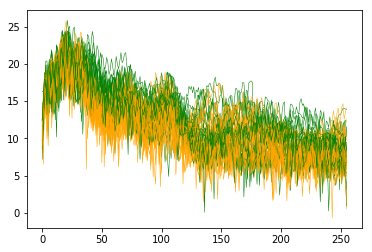

In [30]:
for i in range(50):
    plt.plot(range(256), X[i], linewidth=0.5, color=('orange', 'green')[y[i,0]])

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=1000, random_state=30)

/home/andrey/tensorflow/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [32]:
ls = sm.Logit(y_train, sm.add_constant(X_train)).fit(disp=False)
r = ls.predict(sm.add_constant(X_train)) - np.squeeze(y_train)
print('Training error', r @ r / X_train.shape[0])
r = ls.predict(sm.add_constant(X_test)) - np.squeeze(y_test)
print('Test error', r @ r / X_test.shape[0])

Training error 0.06351566159872234
Test error 0.19756741975724595


/home/andrey/tensorflow/lib/python3.6/site-packages/statsmodels/discrete/discrete_model.py:1674: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/andrey/tensorflow/lib/python3.6/site-packages/statsmodels/discrete/discrete_model.py:1724: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


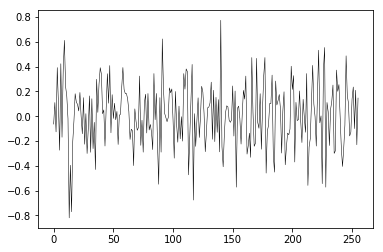

In [33]:
b_hat = ls.params[1:]
plt.plot(range(256), b_hat, linewidth=0.5, color='black')

In [34]:
def dk(x, xi_k, xi_K):
    return (max(0, x-xi_k)**3 - max(0, x-xi_K)**3) / (xi_K-xi_k)

def do_nc_expansion(x, xis):
    X = np.zeros(shape=(x.shape[0], len(xis)))
    for i in range(X.shape[0]):
        X[i, 0] = 1
        X[i, 1] = x[i]
        for k in range(2, len(xis)):
            X[i, k] = dk(x[i], xis[k-2], xis[-1]) - dk(x[i], xis[-2], xis[-1])
    return X

In [41]:
H = do_nc_expansion(np.linspace(1, 256, 256), np.linspace(1, 256, 12))

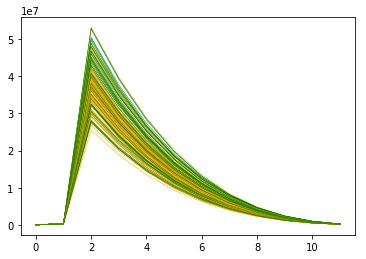

In [42]:
X_train_filtered = (H.T @ X_train.T).T
X_test_filtered = (H.T @ X_test.T).T
for i in range(150):
    plt.plot(range(12), X_train_filtered[i], linewidth=0.5, color=('orange', 'green')[y_train[i,0]])

In [43]:
ls = sm.Logit(y_train, sm.add_constant(X_train_filtered)).fit(disp=False)
r = ls.predict(sm.add_constant(X_train_filtered)) - np.squeeze(y_train)
print('Training error', r @ r / X_train.shape[0])
r = ls.predict(sm.add_constant(X_test_filtered)) - np.squeeze(y_test)
print('Test error', r @ r / X_test.shape[0])

Training error 0.13164983502513575
Test error 0.12083691355347508


/home/andrey/tensorflow/lib/python3.6/site-packages/statsmodels/discrete/discrete_model.py:1674: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/andrey/tensorflow/lib/python3.6/site-packages/statsmodels/discrete/discrete_model.py:1724: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


In [44]:
b_hat_filtered = H @ ls.params[1:]

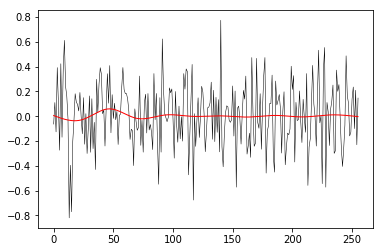

In [45]:
plt.plot(range(256), b_hat, linewidth=0.5, color='black')
plt.plot(range(256), b_hat_filtered, linewidth=1, color='red')